<h1 align = "center">Titanic Model</h1>

<h2 align = "center">Cloud Computing Project - Predict Titanic Survivor</h2>
<h4 align = "center">ROULET Maria Paula - ROUX Dorian</h4>

## Import the Required Packages

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import zscore
from scipy.stats import iqr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('Datasets/Cleaned/cleaned_train.csv', index_col=1).iloc[:, 1:]
test = pd.read_csv('Datasets/Cleaned/cleaned_test.csv', index_col=1).iloc[:, 1:]

## Feature Engineering

#### In the model, we decide to not take into account the ticker number

In [3]:
train = train.drop('Ticket', axis=1)
test = test.drop('Ticket', axis=1)

#### In the model, we decide to not take into account the Passenger's Age

In [4]:
train['Age'] = train['Age'].astype(int)
test['Age'] = test['Age'].astype(int)

#### In the model, we decide to not take into account the Passenger's Sex

In [5]:
print('Train data set:', np.unique(train.Sex))
print('Test data set:', np.unique(test.Sex))

Train data set: ['female' 'male']
Test data set: ['female' 'male']


In [6]:
train['n_Sex'] = train.Sex.replace(np.unique(train.Sex), [num for num in range(len(np.unique(train.Sex)))])
test['n_Sex'] = test.Sex.replace(np.unique(test.Sex), [num for num in range(len(np.unique(test.Sex)))])

#### In the model, we decide to take into account the port of Embarkation

In [7]:
print('Train data set:', np.unique(train.Embarked))
print('Test data set:', np.unique(test.Embarked))

Train data set: ['C' 'Q' 'S']
Test data set: ['C' 'Q' 'S']


In [8]:
# C = 1 / Q = 2 / S = 3
train['n_Embarked'] = train.Embarked.replace(np.unique(train.Embarked), [num for num in range(len(np.unique(train.Embarked)))])
test['n_Embarked'] = test.Embarked.replace(np.unique(test.Embarked), [num for num in range(len(np.unique(test.Embarked)))])

#### In the model, we decide to take into account the name title (Mr, Mrs, Miss)

In [9]:
def add_title(data):
    data['Name_Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    data.Name_Title = data.Name_Title.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data.Name_Title = data.Name_Title.replace('Mlle', 'Miss')
    data.Name_Title = data.Name_Title.replace('Ms', 'Miss')
    data.Name_Title = data.Name_Title.replace('Mme', 'Mrs')
    
    # Map from strings to numerical variables.
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    
    data.Name_Title = data.Name_Title.map(title_mapping)
    data.Name_Title = data.Name_Title.fillna(0)

    return data

train = add_title(train)
test = add_title(test)

train = train.drop('Name', axis=1)
test = test.drop('Name', axis=1)

#### In the model, we decide to take into account the number of relative and if the person traveled alone

In [10]:
def add_relative(data):
    data['Travel_Relative'] = data['SibSp'] + data['Parch']
    data.loc[data['Travel_Relative'] > 0, 'Travel_Alone'] = 0
    data.loc[data['Travel_Relative'] == 0, 'Travel_Alone'] = 1
    
    data['Travel_Relative'] = data['Travel_Relative'].astype(int)
    data['Travel_Alone'] = data['Travel_Alone'].astype(int)

    return data

train = add_relative(train)
test = add_relative(test)

train = train.drop(['SibSp', 'Parch'], axis=1)
test = test.drop(['SibSp', 'Parch'], axis=1)

#### In the model, we decide to cut into quarter classes the Fare

In [11]:
train['CatFare'] = pd.qcut(train["Fare"], q=4, labels=False)
test['CatFare'] = pd.qcut(test["Fare"], q=4, labels=False)

## Correlation after Feature Engineering

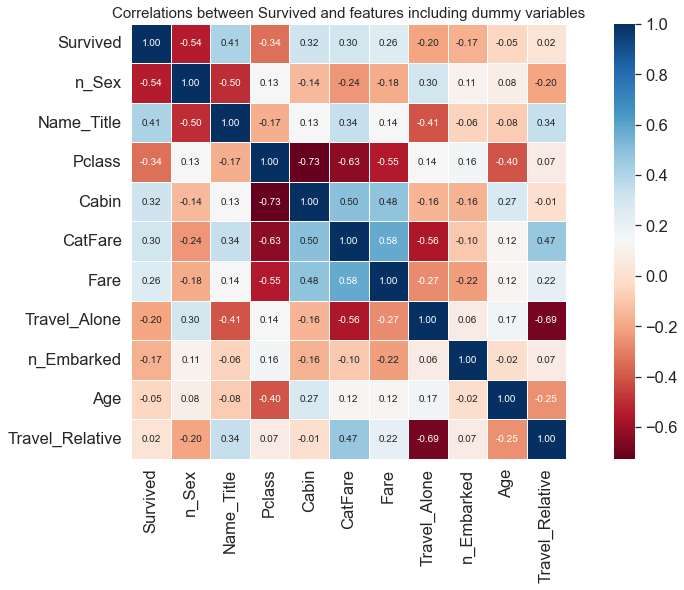

In [12]:
corrmat = abs(train.iloc[:train.shape[0],:].corr())
plt.figure(figsize=(17, 8))
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Survived')['Survived'].index
cm = np.corrcoef(train.iloc[:train.shape[0],:][cols].values.T)
sns.set(font_scale=1.50)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,
                 cmap = 'RdBu', linecolor = 'white', linewidth = 1)
plt.title("Correlations between Survived and features including dummy variables", fontsize =15)
plt.show()

## Model

### Sequential

In [15]:
X_train_seq = train[['Pclass', 'Cabin', 'Age', 'n_Sex', 'n_Embarked', 'Name_Title', 'Travel_Relative', 'Travel_Alone']]

y_train_seq  = train['Survived']

X_test_seq = test[['Pclass', 'Cabin', 'Age', 'n_Sex', 'n_Embarked', 'Name_Title', 'Travel_Relative', 'Travel_Alone']]

In [16]:
X_train_seq, X_val, y_train_seq, y_val = train_test_split(X_train_seq, y_train_seq, test_size = 0.3, random_state = 42)

In [30]:
model = tf.keras.models.Sequential([
tf.keras.layers.Dense(100, activation="relu"),
tf.keras.layers.Dense(50, activation="relu"),
tf.keras.layers.Dense(1,activation="sigmoid")
])

opt = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(X_train_seq, y_train_seq, epochs=1000, validation_data=(X_val, y_val))

Epoch 1/1000
20/20 [==============================] - 1s 18ms/step - loss: 0.9566 - accuracy: 0.5345 - val_loss: 0.6644 - val_accuracy: 0.5858
Epoch 2/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.6409 - accuracy: 0.6356 - val_loss: 0.6472 - val_accuracy: 0.6045
Epoch 3/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.6328 - accuracy: 0.6324 - val_loss: 0.6513 - val_accuracy: 0.5858
Epoch 4/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.6252 - accuracy: 0.6372 - val_loss: 0.6536 - val_accuracy: 0.5821
Epoch 5/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.6231 - accuracy: 0.6404 - val_loss: 0.6402 - val_accuracy: 0.5858
Epoch 6/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.6208 - accuracy: 0.6404 - val_loss: 0.6362 - val_accuracy: 0.5821
Epoch 7/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.6148 - accuracy: 0.6485 - val_loss: 0.6490 - val_accuracy: 0.5858
Ep

In [31]:
model.evaluate(X_val,y_val)

9/9 [==============================] - 0s 4ms/step - loss: 0.4383 - accuracy: 0.8022


[0.43831661343574524, 0.8022388219833374]

In [32]:
seq_predict_df = pd.DataFrame({'Survived_Perct': [float(pred) for pred in model.predict(X_test_seq)]})
seq_predict_df['Survived'] = round(seq_predict_df.Survived_Perct).astype(int)
seq_predict_df

,Survived_Perct,Survived
0,0.082626,0
1,0.455416,0
2,0.059882,0
3,0.072375,0
4,0.551033,1
...,...,...
413,0.074674,0
414,0.981392,1
415,0.058737,0
416,0.074675,0


## Export the model

In [20]:
model.save("sequential")


INFO:tensorflow:Assets written to: sequential\assets


---

# <h1 align = "center">End of the Model</h1>